Mounting the Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

###Data Prepration


**In the following cell:**
1.   Importing necessary libraries
2.   create path variables

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# for showing images in the cell outputs (Jupyter Notebooks / Google Colab)
from tensorflow.keras import regularizers
from IPython.display import display
from ipywidgets import Image
from keras.regularizers import l2, l1
import random
from scipy.optimize import differential_evolution
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.applications.resnet import preprocess_input as resnet_preprocess
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess
from keras.layers.merge import concatenate


BASE_DIR = '/content/drive/Shareddrives/DeepLearningProject/Coccomini_Gholami_Zara/'
DATA_DIR = BASE_DIR + 'data/numpy data/'
MODEL_DIR = BASE_DIR + 'models/'
PUBLIC_TEST_TENSOR = DATA_DIR + 'public_test_tensor.npy'
PUBLIC_TEST_LABELS = DATA_DIR + 'public_test_labels.npy'
PRIVATE_TEST_TENSOR = DATA_DIR + 'private_test_tensor.npy'

TRAIN_LABELS = DATA_DIR + 'train_labels.npy'
TRAIN_TENSOR = DATA_DIR + 'train_tensor.npy'


EPOCH = 40
BATCH_SIZE = 16
EARLY_STOP_PATIENCE = 3

Loading data from the direcotories

In [ ]:
raw_train_data = np.load(TRAIN_TENSOR).reshape((5352, 150, 150, 1))
raw_train_labels = np.load(TRAIN_LABELS)
raw_test_data = np.load(PUBLIC_TEST_TENSOR).reshape((672, 150, 150, 1))
raw_test_labels = np.load(PUBLIC_TEST_LABELS)
private_test_data = np.load(PRIVATE_TEST_TENSOR) # loading private test
# 0: baseline; 1-2: masses (b-m); 3-4: calcifications (b-m)
# Convert the dataset into a two-class one with only considering "masses" (0) and "calcifications" (1).
def collapse_labels(labels):
  collapsed_labels = np.where(labels < 3, 0, 1)
  return collapsed_labels

#shuffle data
def shuffle_data(data, labels):
  c = list(zip(data, labels))
  random.shuffle(c)
  t_data, t_labels = zip(*c)
  t_data = np.array(t_data)
  t_labels = np.array(t_labels)
  return t_data, t_labels

# Datasets without baseline (class 0)
train_data_no_baseline =  raw_train_data[1::2]
train_labels_no_baseline =  raw_train_labels[1::2]
test_data_no_baseline =  raw_test_data[1::2]
test_labels_no_baseline =  raw_test_labels[1::2]

test_data_no_baseline, test_labels_no_baseline = shuffle_data(test_data_no_baseline, test_labels_no_baseline)
#copy grayscale channel to channel 2 and 3 because pretrained models work with rgb images
train_data_no_baseline_RGB = np.concatenate((train_data_no_baseline[:], train_data_no_baseline[:], train_data_no_baseline[:]), axis=3);
test_data_no_baseline_RGB = np.concatenate((test_data_no_baseline[:], test_data_no_baseline[:], test_data_no_baseline[:]), axis=3);

# Collapse labels in mass and calcification classes
collapsed_train_labels = collapse_labels(train_labels_no_baseline)
collapsed_test_labels = collapse_labels(test_labels_no_baseline)

Data Augmentation

In [ ]:
# data augmentation hyperparameters
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 360
FILL_MODE='nearest'
#Image data generator for pretrained or tuned models
#training data
def get_pt_train_datagen(preprocess):
  return ImageDataGenerator(
        preprocessing_function=preprocess,
        horizontal_flip = HORIZONTAL_FLIP,
        vertical_flip = VERTICAL_FLIP, 
        rotation_range = ROTATION_RANGE,
        fill_mode=FILL_MODE
      )
#validation data
def get_pt_validation_datagen(preprocess):
  return ImageDataGenerator(
        preprocessing_function=preprocess
      )
  
#get test generator
def get_pt_test_datagen(preprocess=None):
  return ImageDataGenerator()


Early Stop Function

In [ ]:
#Early stop conditon 
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE)

###Voting Functions

In [ ]:
# make an ensemble prediction for multi-class classification
def ensemble_predict(classifiers, test_data, sigmoid=False):
  # make predictions
  predicts = [model.predict(test_data) for model in classifiers]
  # weighted sum across ensemble classifiers
  summed = np.sum(predicts, axis=0) / len(classifiers)
  # argmax across classes
  if sigmoid:
      return np.where(np.array(summed) > 0.5, 1, 0).flatten()
  return np.argmax(summed, axis=-1)

    # evaluate a specific number of classifiers in an ensemble
def evaluate_n_classifiers(classifiers, n_classifiers, test_data, labels, sigmoid=False):
	# select a subset of classifiers
    subset = classifiers[:n_classifiers]
	# make prediction
    predicted = ensemble_predict(subset, test_data, sigmoid)
	# calculate accuracy
    return accuracy_score(labels, predicted)
 
 # make an ensemble prediction for multi-class classification
def ensemble_predictions(classifiers, weights, test_data, sigmoid=False):
    # make predictions
    predicts = [model.predict(test_data) for model in classifiers]
    predicts = np.array(predicts)
    # weighted sum across ensemble classifiers
    summed = np.tensordot(predicts, weights, axes=((0),(0)))
    # argmax across classes
    if sigmoid:
        return np.where(np.array(summed) > 0.5, 1, 0).flatten()
    return np.argmax(summed, axis=1)
 
#evaluate a specific number of classifiers in an ensemble
def evaluate_ensemble(classifiers, weights, test_data, test_label, sigmoid=False):
	# make prediction
    predicted = ensemble_predictions(classifiers, weights, test_data, sigmoid)
	# calculate accuracy
    return accuracy_score(test_label, predicted)
 
# normalize a vector to have unit norm
def normalize(weights):
	# calculate l1 vector norm
	result = np.linalg.norm(weights, 1)
	# check for a vector of all zeros
	if result == 0.0:
		return weights
	# return normalized vector (unit norm)
	return weights / result


from itertools import product
    # grid search weights
def grid_search(classifiers, test_data, test_labels, sigmoid=False):
	# define weights to consider
    # w = [0.0, 0.25, 0.5, 0.75, 1.0]
    w = [0.0, 0.5, 1.0]
    best_score, best_weights = 0.0, None
	# iterate all possible combinations (cartesian product)
    j = 0
    for weights in product(w, repeat=len(classifiers)):
		# skip if all weights are equal
        if len(set(weights)) == 1:
            continue
		# hack, normalize weight vector
        weights = normalize(weights)
		# evaluate weights
        score = evaluate_ensemble(classifiers, weights, test_data, test_labels, sigmoid)
        if score > best_score:
            best_score, best_weights = score, weights
            print('>%s %.4f' % (best_weights, best_score))
    return list(best_weights)


    # loss function for optimization process, designed to be minimized
def loss_function(weights, classifiers, img_generator, test_label):
	# normalize weights
    normalized = normalize(weights)
    # calculate error rate
    return 1.0 - evaluate_ensemble(classifiers, normalized, img_generator, test_label)
	

###Stack Model Declaration

In the following cell:



1.   load_models: Function for loading pretrained models
2.   define_stacked_model: Function returning the Stack Model




In [ ]:
#model_type can be pretrained
#by using model_type we specifies what type of models to load
def load_models(model_type):
  all_models = list()
  filenames = [f for f in os.listdir(MODEL_DIR+"MC/")]
  f_names = []
  for f in filenames:
    if f.split(model_type)[0] == "" and "tuned" not in f and "stack" not in f:
      all_models.append(keras.models.load_model(os.path.join(MODEL_DIR+"MC/"+f)))
      print('model', f, 'is loaded')
      f_names.append(f)
  return all_models, f_names


#loading tuned models
def load_tuned_models():
  all_models = list()
  filenames = [f for f in os.listdir(MODEL_DIR+"MC/")]
  f_names = []
  for f in filenames:
    if "tuned" in f and "baseline" not in f and "stack" not in f:
      all_models.append(models.load_model(MODEL_DIR+"MC/"+f))
      f_names.append(f)
      print('model', f, 'is loaded')

  return all_models, f_names


def show_plots(history):
  #plot the accurasy of the Training and Validation Set
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def define_stacked_model(hidden_neurons, output_neurons, loss, last_activation, optimizer, classifiers):
	# update all layers in all models to not be trainable
  for i in range(len(classifiers)):
    model = classifiers[i]
    model.input._name = 'ensemble_' + str(i+1) + '_' + model.input._name 
    for layer in model.layers:
			# make not trainable
      layer.trainable = False
			# rename to avoid 'unique layer name' issue
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

	# define multi-headed input
  ensemble_visible = [model.input for model in classifiers]
	# concatenate merge output from each model
  ensemble_outputs = [model.output for model in classifiers]
  merge = layers.Concatenate()(ensemble_outputs)
  hidden = layers.Dense(hidden_neurons, activation='relu')(merge)
  output = layers.Dense(output_neurons, activation=last_activation)(hidden)
  model = models.Model(inputs=ensemble_visible, outputs=output)
	# compile
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  # model.summary()
  return model
  


####In the following cell:

Defining functions for loading pretrained models

1.   get_train_generators: Function returning the data generator for stack model
2.   fit_stacked_model: Functdion for fitting the stack model


In [ ]:
def get_generators(preprocessing_functions, image_generator_function, data, labels):
  train_generators = []
  for pf in preprocessing_functions:
    td = image_generator_function(pf)
    train_generators.append(td.flow(data, labels, batch_size=BATCH_SIZE))
  while True:
    trains = []
    lbl = ""
    for i in range(len(preprocessing_functions)):
      next = train_generators[i].next()
      trains.append(next[0])
      lbl = next[1]
    yield trains, lbl


# fit a stacked model
def fit_stacked_model(input_model, preprocessing_functions, input_data, input_labels, split_size, train_datagen_func, valid_datagen_func):
  train_data, validation_data, train_labels, validation_labels = train_test_split(
                                                                                  input_data,
                                                                                  input_labels,
                                                                                  train_size=split_size,
                                                                                  random_state=42,
                                                                                  shuffle=True
                                                                                )
  #defining training data generator
  training = get_generators(
      preprocessing_functions=preprocessing_functions, 
      image_generator_function=train_datagen_func, 
      data=train_data, 
      labels=train_labels)
  #defining validation data generator
  validation = get_generators(
      preprocessing_functions=preprocessing_functions, 
      image_generator_function=valid_datagen_func, 
      data=validation_data, 
      labels=validation_labels)
  #fitting the model on the created generators
  fit_results = input_model.fit(
    training,
    epochs=EPOCH,
    steps_per_epoch=int(np.ceil(len(train_data) / float(BATCH_SIZE))),
    validation_data=validation,
    validation_steps=int(np.ceil(len(validation_data) / float(BATCH_SIZE))),
    callbacks=[early_stop]
  )
  return fit_results


##Ensemble Models Training 

###Pretrained Models

####Stack Model

Loading pretrained models to create stack one

Then train the stack model on the dataset

model pretrained_inception.h5 is loaded
model pretrained_resnet.h5 is loaded
model pretrained_vgg16.h5 is loaded
Epoch 1/40
134/134 [==============================] - 50s 278ms/step - loss: 0.6278 - accuracy: 0.6053 - val_loss: 0.5829 - val_accuracy: 0.6716
Epoch 2/40
134/134 [==============================] - 33s 251ms/step - loss: 0.5521 - accuracy: 0.7447 - val_loss: 0.5311 - val_accuracy: 0.7668
Epoch 3/40
134/134 [==============================] - 33s 251ms/step - loss: 0.5077 - accuracy: 0.7972 - val_loss: 0.4917 - val_accuracy: 0.7836
Epoch 4/40
134/134 [==============================] - 33s 251ms/step - loss: 0.4592 - accuracy: 0.8304 - val_loss: 0.4745 - val_accuracy: 0.7966
Epoch 5/40
134/134 [==============================] - 33s 251ms/step - loss: 0.4466 - accuracy: 0.8079 - val_loss: 0.4639 - val_accuracy: 0.7985
Epoch 6/40
134/134 [==============================] - 34s 251ms/step - loss: 0.4472 - accuracy: 0.8040 - val_loss: 0.4620 - val_accuracy: 0.7780
Epoch 7/40
134/13

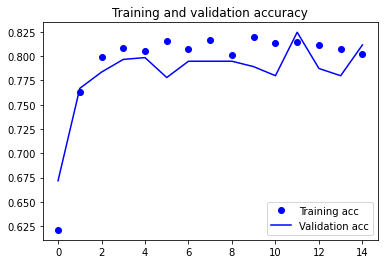

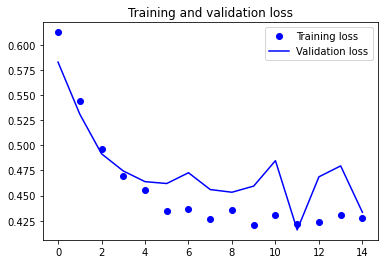

In [ ]:
classifiers, filenames = load_models("pretrained")

pretrained_stacked_model = define_stacked_model(
    hidden_neurons=10,
    output_neurons=1, 
    loss="binary_crossentropy",
    last_activation="sigmoid",
    optimizer='RMSprop', 
    classifiers=classifiers)
#for pretrained models, the size of the following list should be equal to the size of level0 models in stack model
preprocessing_functions = [inception_v3_preprocess, resnet_preprocess, vgg16_preprocess]
# fit stacked model on test dataset
history = fit_stacked_model(input_model=pretrained_stacked_model, 
                  preprocessing_functions=preprocessing_functions, 
                  input_data=train_data_no_baseline_RGB, 
                  input_labels=collapsed_train_labels, 
                  split_size=0.8, 
                  train_datagen_func=get_pt_train_datagen, 
                  valid_datagen_func=get_pt_validation_datagen)
show_plots(history)

Testing the pretrained ensemble model

In [ ]:
test_gen = get_generators(
      preprocessing_functions=preprocessing_functions, 
      image_generator_function=get_pt_test_datagen, 
      data=test_data_no_baseline_RGB, 
      labels=collapsed_test_labels)
test_loss, test_accuracy = pretrained_stacked_model.evaluate(test_gen, steps=np.ceil(len(test_data_no_baseline_RGB)/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

predicted = pretrained_stacked_model.predict([test_data_no_baseline_RGB] * len(filenames))
res = np.where(np.array(predicted) > 0.5, 1, 0).flatten()
print('Accuracy of prediction:',accuracy_score(collapsed_test_labels, res))

21/21 [==============================] - 1s 67ms/step - loss: 0.4727 - accuracy: 0.7887
Accuracy on test dataset: 0.788690447807312
Accuracy of prediction: 0.7797619047619048


Save the model

In [ ]:
pretrained_stacked_model.save(os.path.join(MODEL_DIR,'MC/pretrained_stack_model.h5'))

####Voting Model

Srouce:
https://machinelearningmastery.com/weighted-average-ensemble-for-deep-learning-neural-networks/

model pretrained_inception.h5 is loaded
model pretrained_resnet.h5 is loaded
model pretrained_vgg16.h5 is loaded
21/21 [==============================] - 2s 24ms/step - loss: 0.5388 - accuracy: 0.7738
Model pretrained_inception.h5: 0.7738
21/21 [==============================] - 1s 23ms/step - loss: 0.3901 - accuracy: 0.8304
Model pretrained_resnet.h5: 0.8304
21/21 [==============================] - 1s 21ms/step - loss: 0.4829 - accuracy: 0.7857
Model pretrained_vgg16.h5: 0.7857
Accuracy 0.7966 (0.0243)


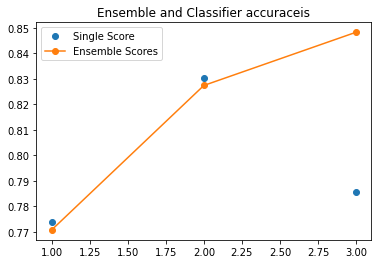

In [ ]:
classifiers, filenames = load_models("pretrained")
preprocessing_functions = [inception_v3_preprocess, resnet_preprocess, vgg16_preprocess]
c_len = len(classifiers)
ensemble_scores, single_scores = list(), list()
i = 1
for c,f in zip(classifiers,filenames):
    p_f = None
    if "vgg16" in f:
        p_f = vgg16_preprocess
    elif "inception" in f:
        p_f = inception_v3_preprocess
    else:
        p_f = resnet_preprocess
    test_gen = get_pt_validation_datagen(p_f)
    test_d = test_gen.flow(test_data_no_baseline_RGB, collapsed_test_labels, batch_size=BATCH_SIZE)
    _, test_acc = c.evaluate(test_d)
    c.predict(test_data_no_baseline_RGB)
    print('Model %s: %.4f' % (f, test_acc))
    single_scores.append(test_acc)
    ensemble_score = evaluate_n_classifiers(classifiers, i, test_data_no_baseline_RGB, collapsed_test_labels, sigmoid=True)
    ensemble_scores.append(ensemble_score)
    i += 1

# summarize average accuracy of a single final model
print('Accuracy %.4f (%.4f)' % (np.mean(single_scores), np.std(single_scores)))
# plot score vs number of ensemble classifiers
x_axis = [i for i in range(1, len(classifiers)+1)]
plt.plot(x_axis, single_scores, marker='o', linestyle="None",label='Single Score')
plt.plot(x_axis, ensemble_scores, marker='o', label='Ensemble Scores')
plt.title('Ensemble and Classifier accuraceis')
plt.legend()
plt.show()

Using Grid Search to improve the voting model

In [ ]:
classifiers, filenames = load_models("pretrained")
weights = [1.0/c_len for _ in range(c_len)]
score = evaluate_ensemble(classifiers, weights, test_data_no_baseline_RGB, collapsed_test_labels, sigmoid=True)
print('Equal Weights Score: %.4f' % score)
# grid search weights
weights = grid_search(classifiers, test_data_no_baseline_RGB, collapsed_test_labels, sigmoid=True)
score = evaluate_ensemble(classifiers, weights, test_data_no_baseline_RGB, collapsed_test_labels, sigmoid=True)
print('Grid Search Weights: %s, Score: %.4f' % (weights, score))

model pretrained_inception.h5 is loaded
model pretrained_resnet.h5 is loaded
model pretrained_vgg16.h5 is loaded
Equal Weights Score: 0.8482
>[0. 0. 1.] 0.7827
>[0. 1. 0.] 0.8304
>[0.  0.5 0.5] 0.8393
>[0.         0.66666667 0.33333333] 0.8512
>[0.2 0.4 0.4] 0.8542
Grid Search Weights: [0.2, 0.4, 0.4], Score: 0.8542


###Tuned Models

####Stack Model

Loading tuned models to create stack one

Then train the stack model on the dataset

model pretrained_inception_tuned.h5 is loaded
model pretrained_resnet_tuned.h5 is loaded
model pretrained_vgg16_tuned.h5 is loaded
Epoch 1/40
134/134 [==============================] - 42s 270ms/step - loss: 0.8406 - accuracy: 0.4201 - val_loss: 0.6954 - val_accuracy: 0.5485
Epoch 2/40
134/134 [==============================] - 34s 254ms/step - loss: 0.6757 - accuracy: 0.5294 - val_loss: 0.6183 - val_accuracy: 0.6437
Epoch 3/40
134/134 [==============================] - 34s 253ms/step - loss: 0.6057 - accuracy: 0.6867 - val_loss: 0.5392 - val_accuracy: 0.8228
Epoch 4/40
134/134 [==============================] - 33s 251ms/step - loss: 0.5406 - accuracy: 0.8238 - val_loss: 0.4845 - val_accuracy: 0.8470
Epoch 5/40
134/134 [==============================] - 33s 250ms/step - loss: 0.4800 - accuracy: 0.8501 - val_loss: 0.4228 - val_accuracy: 0.8713
Epoch 6/40
134/134 [==============================] - 34s 252ms/step - loss: 0.4228 - accuracy: 0.8572 - val_loss: 0.4020 - val_accuracy: 0.8545

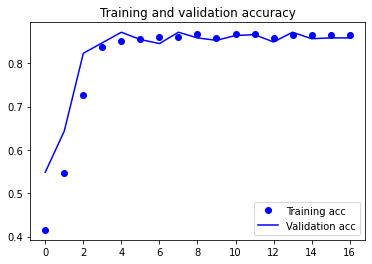

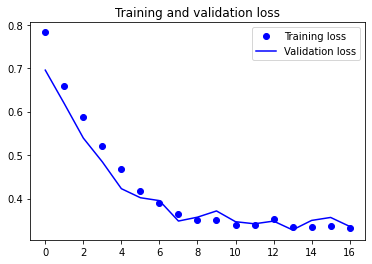

In [ ]:
classifiers, filenames = load_tuned_models()
tuned_stacked_model = define_stacked_model(
    hidden_neurons=10,
    output_neurons=1, 
    loss="binary_crossentropy",
    last_activation="sigmoid",
    optimizer='RMSprop', 
    classifiers=classifiers)
#for pretrained models, the size of the following list should be equal to the size of level0 models in stack model
preprocessing_functions = [inception_v3_preprocess, resnet_preprocess, vgg16_preprocess]
# fit stacked model on test dataset
history = fit_stacked_model(
                  input_model=tuned_stacked_model, 
                  preprocessing_functions=preprocessing_functions, 
                  input_data=train_data_no_baseline_RGB, 
                  input_labels=collapsed_train_labels, 
                  split_size=0.8, 
                  train_datagen_func=get_pt_train_datagen, 
                  valid_datagen_func=get_pt_validation_datagen)
show_plots(history)


Testing the tuned ensemble model

In [ ]:
classifiers, filenames = load_tuned_models()
print(filenames)
test_gen = get_generators(
      preprocessing_functions=preprocessing_functions, 
      image_generator_function=get_pt_test_datagen, 
      data=test_data_no_baseline_RGB, 
      labels=collapsed_test_labels)
test_loss, test_accuracy = tuned_stacked_model.evaluate(test_gen, steps=np.ceil(len(test_data_no_baseline_RGB)/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

predicted = tuned_stacked_model.predict([test_data_no_baseline_RGB] * len(filenames))
res = np.where(np.array(predicted) > 0.5, 1, 0).flatten()
print('Accuracy of prediction:',accuracy_score(collapsed_test_labels, res))

model pretrained_inception_tuned.h5 is loaded
model pretrained_resnet_tuned.h5 is loaded
model pretrained_vgg16_tuned.h5 is loaded
['pretrained_inception_tuned.h5', 'pretrained_resnet_tuned.h5', 'pretrained_vgg16_tuned.h5']
21/21 [==============================] - 1s 70ms/step - loss: 0.3837 - accuracy: 0.8333
Accuracy on test dataset: 0.8333333134651184
Accuracy of prediction: 0.8363095238095238


Save the model

In [ ]:
tuned_stacked_model.save(os.path.join(MODEL_DIR,'MC/tuned_stack_model.h5'))

####Voting Model

Srouce:
https://machinelearningmastery.com/weighted-average-ensemble-for-deep-learning-neural-networks/

model pretrained_inception_tuned.h5 is loaded
model pretrained_resnet_tuned.h5 is loaded
model pretrained_vgg16_tuned.h5 is loaded
21/21 [==============================] - 2s 24ms/step - loss: 0.4073 - accuracy: 0.8065
Model pretrained_inception_tuned.h5: 0.8065
21/21 [==============================] - 1s 24ms/step - loss: 0.3571 - accuracy: 0.8333
Model pretrained_resnet_tuned.h5: 0.8333
21/21 [==============================] - 1s 21ms/step - loss: 0.3879 - accuracy: 0.8452
Model pretrained_vgg16_tuned.h5: 0.8452
Accuracy 0.8284 (0.0162)


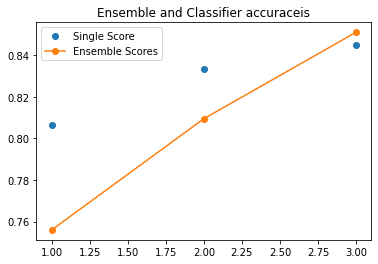

In [ ]:
classifiers, filenames = load_tuned_models()
c_len = len(classifiers)
ensemble_scores, single_scores = list(), list()
i = 1
for c,f in zip(classifiers,filenames):
    p_f = None
    if "vgg16" in f:
        p_f = vgg16_preprocess
    elif "inception" in f:
        p_f = inception_v3_preprocess
    else:
        p_f = resnet_preprocess
    test_gen = get_pt_validation_datagen(p_f)
    test_d = test_gen.flow(test_data_no_baseline_RGB, collapsed_test_labels, batch_size=BATCH_SIZE)
    _, test_acc = c.evaluate(test_d)
    c.predict(test_data_no_baseline_RGB)
    print('Model %s: %.4f' % (f, test_acc))
    single_scores.append(test_acc)
    ensemble_score = evaluate_n_classifiers(classifiers, i, test_data_no_baseline_RGB, collapsed_test_labels, sigmoid=True)
    ensemble_scores.append(ensemble_score)
    i += 1

# summarize average accuracy of a single final model
print('Accuracy %.4f (%.4f)' % (np.mean(single_scores), np.std(single_scores)))
# plot score vs number of ensemble classifiers
x_axis = [i for i in range(1, len(classifiers)+1)]
plt.plot(x_axis, single_scores, marker='o', linestyle="None",label='Single Score')
plt.plot(x_axis, ensemble_scores, marker='o', label='Ensemble Scores')
plt.title('Ensemble and Classifier accuraceis')
plt.legend()
plt.show()

Using Grid Search to improve the voting model

In [ ]:
classifiers, filenames = load_tuned_models()
weights = [1.0/c_len for _ in range(c_len)]
score = evaluate_ensemble(classifiers, weights, test_data_no_baseline_RGB, collapsed_test_labels, sigmoid=True)
print('Equal Weights Score: %.4f' % score)
# grid search weights
weights = grid_search(classifiers, test_data_no_baseline_RGB, collapsed_test_labels, sigmoid=True)
score = evaluate_ensemble(classifiers, weights, test_data_no_baseline_RGB, collapsed_test_labels, sigmoid=True)
print('Grid Search Weights: %s, Score: %.4f' % (weights, score))

model pretrained_inception_tuned.h5 is loaded
model pretrained_resnet_tuned.h5 is loaded
model pretrained_vgg16_tuned.h5 is loaded
Equal Weights Score: 0.8512
>[0. 0. 1.] 0.8482
>[0.  0.5 0.5] 0.8780
Grid Search Weights: [0.0, 0.5, 0.5], Score: 0.8780
